In [68]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [167]:
df = pd.read_csv('../../parallel_energy.csv')

In [168]:
en_0 = df['e_tot'][0]

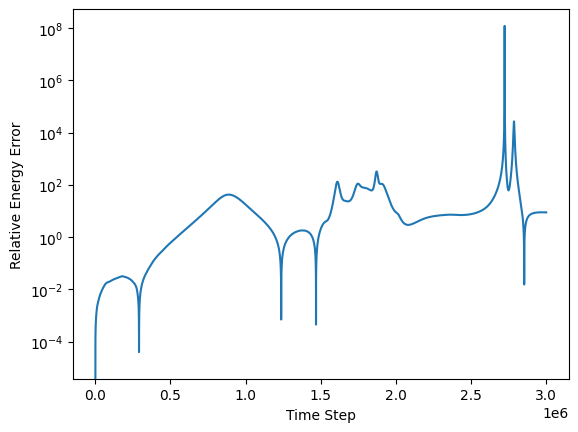

In [169]:
plt.plot(df['t_step'], np.abs((df['e_tot'] - en_0)/en_0))
plt.xlabel('Time Step')
plt.ylabel('Relative Energy Error')
plt.yscale('log')

In [163]:
df = pd.read_csv('../../parallel_output.csv')

In [164]:
N = df['ID'].max()+1

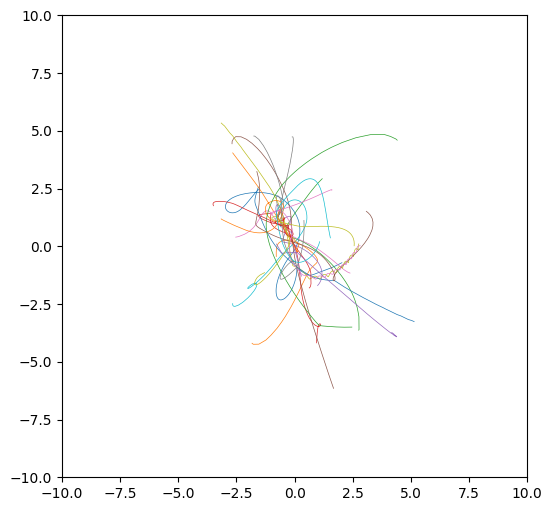

In [166]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for i in range(N):
    ax.plot(df[df['ID']==i]['pos_x'], df[df['ID']==i]['pos_y'], linewidth=0.5)

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

plt.show()

In [ ]:
import matplotlib.animation as animation
from matplotlib.pyplot import cm

# Create figure and axis
fig, ax = plt.subplots(figsize=(6,6))
color = cm.rainbow(np.linspace(0, 1, N))

# Set axis limits based on previous plot
# ax.set_xlim(-100,50)
# ax.set_ylim(-100,100)

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)

    current_step = frame * 20

    for i, c in enumerate(color):
        current_data = df[(df['t_step'] == current_step) & (df['ID'] == i)]
        ax.scatter(current_data['pos_x'], current_data['pos_y'], s=10, color=c)

# Create animation
max_steps = df[df['ID']==0]['t_step'].max()
frames = max_steps // 20
ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)

# Save as gif
ani.save('movement.gif', writer='pillow')
plt.close()

# LOOP UNROLLING (p=256)

In [21]:
unroll_df = pd.read_csv('../data/loop_unrolling.csv')

In [22]:
u_1024 = unroll_df[unroll_df['n_bodies']==1024]
u_4096 = unroll_df[unroll_df['n_bodies']==4096]
u_16384 = unroll_df[unroll_df['n_bodies']==16384]
u_65536 = unroll_df[unroll_df['n_bodies']==65536]

uroll_data = [u_1024, u_4096, u_16384, u_65536]

In [23]:
uroll = [0,2,4,16,32]

u_1024_m = []
u_1024_s = []
u_4096_m = []
u_4096_s = []
u_16384_m = []
u_16384_s = []
u_65536_m = []
u_65536_s = []


for i in uroll:
    mmean = u_1024[u_1024['unroll']==i]['gflops'].mean()
    sstd = u_1024[u_1024['unroll']==i]['gflops'].std()
    u_1024_m.append(mmean)
    u_1024_s.append(sstd)

    mmean = u_4096[u_4096['unroll']==i]['gflops'].mean()
    sstd = u_4096[u_4096['unroll']==i]['gflops'].std()
    u_4096_m.append(mmean)
    u_4096_s.append(sstd)

    mmean = u_16384[u_16384['unroll']==i]['gflops'].mean()
    sstd = u_16384[u_16384['unroll']==i]['gflops'].std()
    u_16384_m.append(mmean)
    u_16384_s.append(sstd)

    mmean = u_65536[u_65536['unroll']==i]['gflops'].mean()
    sstd = u_65536[u_65536['unroll']==i]['gflops'].std()
    u_65536_m.append(mmean)
    u_65536_s.append(sstd)


u_mean = [u_1024_m, u_4096_m, u_16384_m, u_65536_m]
u_std = [u_1024_s, u_4096_s, u_16384_s, u_65536_s]

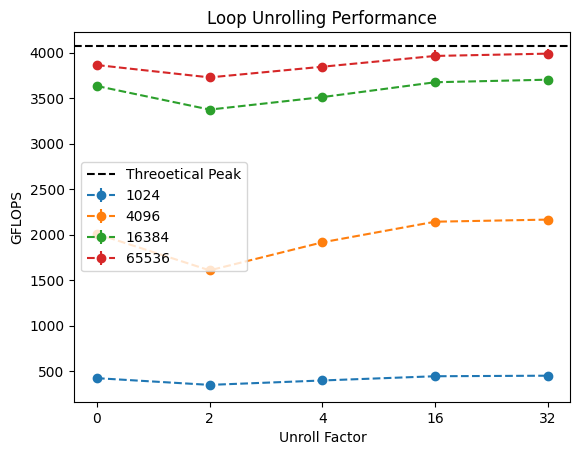

In [26]:
plt.errorbar(np.arange(5), u_1024_m, yerr=u_1024_s, label='1024', fmt='--o')
plt.errorbar(np.arange(5), u_4096_m, yerr=u_4096_s, label='4096', fmt='--o')
plt.errorbar(np.arange(5), u_16384_m, yerr=u_16384_s, label='16384', fmt='--o')
plt.errorbar(np.arange(5), u_65536_m, yerr=u_65536_s, label='65536', fmt='--o')

plt.axhline(4070.5, color='k', linestyle='--', label='Threoetical Peak')

plt.xlabel('Unroll Factor')
plt.ylabel('GFLOPS')
plt.xticks(np.arange(5), uroll)
plt.title('Loop Unrolling Performance')

plt.legend(loc='center left')
plt.show()

In [48]:
u_mean = np.array(u_mean)
for i in range(4):
    print(np.abs((u_mean[i][4] - u_mean[i][3])/u_mean[i][3])*100)

1.343225512586109
1.0810832772654821
0.7664204274997843
0.6369512887441882


# PERFORMANCE INCREASE (p=256, unroll=16)

In [2]:
perf_df = pd.read_csv('../data/performance.csv')

perf_df0 = perf_df[perf_df['yn']==0]
perf_df1 = perf_df[perf_df['yn']==1]

In [3]:
no_roll_m = perf_df0.filter(['n_bodies', 'gflops']).groupby('n_bodies').mean()
yes_roll_m = perf_df1.filter(['n_bodies', 'gflops']).groupby('n_bodies').mean()
no_roll_s = perf_df0.filter(['n_bodies', 'gflops']).groupby('n_bodies').std()
yes_roll_s = perf_df1.filter(['n_bodies', 'gflops']).groupby('n_bodies').std()

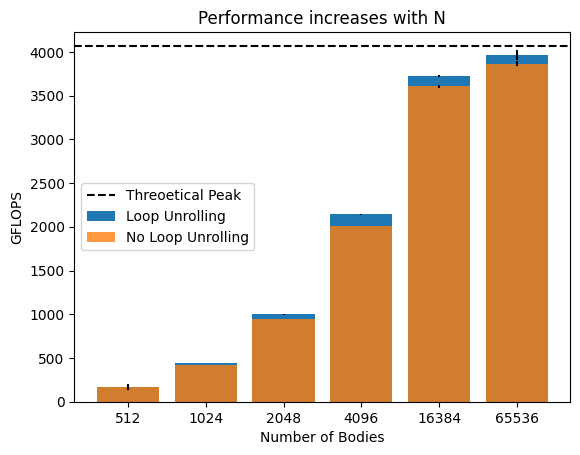

In [30]:
n_bod = np.array(no_roll_m.index)
plt.bar(np.arange(6), yes_roll_m['gflops'], yerr=yes_roll_s['gflops'], label='Loop Unrolling', align='center')
plt.bar(np.arange(6), no_roll_m['gflops'], yerr=no_roll_s['gflops'], label='No Loop Unrolling', align='center', alpha = 0.8)

plt.axhline(4070.5, color='k', linestyle='--', label='Threoetical Peak')

plt.xticks(np.arange(6), n_bod)
plt.xlabel('Number of Bodies')
plt.ylabel('GFLOPS')
plt.title('Performance increases with N')
plt.legend()

# PERFORMANCE INCREASES AS BLOCK SIZE VARIES (unroll=16)

In [31]:
block_df = pd.read_csv('../data/block_size.csv')

In [64]:
block1024_m = block_df[block_df['n_bodies'] == 1024].filter(['p', 'gflops']).groupby(['p']).mean()
block1024_s = block_df[block_df['n_bodies'] == 1024].filter(['p', 'gflops']).groupby(['p']).std()

block4096_m = block_df[block_df['n_bodies'] == 4096].filter(['p', 'gflops']).groupby(['p']).mean()
block4096_s = block_df[block_df['n_bodies'] == 4096].filter(['p', 'gflops']).groupby(['p']).std()

block16384_m = block_df[block_df['n_bodies'] == 16384].filter(['p', 'gflops']).groupby(['p']).mean()
block16384_s = block_df[block_df['n_bodies'] == 16384].filter(['p', 'gflops']).groupby(['p']).std()

block65536_m = block_df[block_df['n_bodies'] == 65536].filter(['p', 'gflops']).groupby(['p']).mean()
block65536_s = block_df[block_df['n_bodies'] == 65536].filter(['p', 'gflops']).groupby(['p']).std()

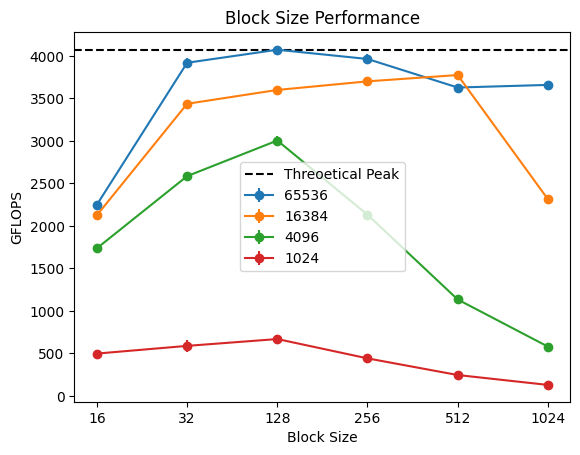

In [70]:
ticks = np.array(block1024_m.index)
plt.errorbar(np.arange(6), block65536_m['gflops'], yerr=block65536_s['gflops'], fmt='-o', label='65536')
plt.errorbar(np.arange(6), block16384_m['gflops'], yerr=block16384_s['gflops'], fmt='-o', label='16384')
plt.errorbar(np.arange(6), block4096_m['gflops'], yerr=block4096_s['gflops'], fmt='-o', label='4096')
plt.errorbar(np.arange(6), block1024_m['gflops'], yerr=block1024_s['gflops'], fmt='-o', label='1024')

plt.axhline(4070.5, color='k', linestyle='--', label='Threoetical Peak')
plt.xticks(np.arange(6), ticks)
plt.xlabel('Block Size')
plt.ylabel('GFLOPS')
plt.title('Block Size Performance')
plt.legend()

plt.show()

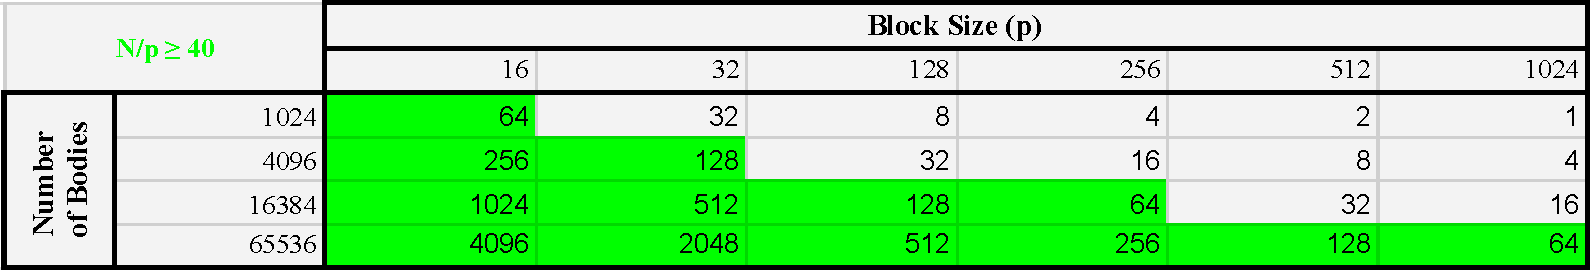

In [69]:
Image.open('./N_over_p_table.png')  

# CALCULATION TIME FOR 1000 STEPS (p=128, unroll=16)

In [71]:
time_df = pd.read_csv('../data/timer.csv')

In [72]:
time_m = time_df.filter(['n_bodies', 'time']).groupby('n_bodies').mean()
time_s = time_df.filter(['n_bodies', 'time']).groupby('n_bodies').std()

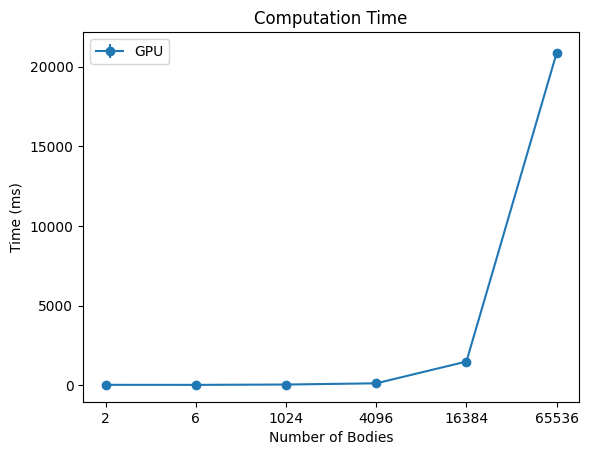

In [78]:
t_bod = np.array(time_m.index)
plt.errorbar(np.arange(6), time_m['time'], yerr=time_s['time'], fmt='-o', label='GPU')
plt.xlabel('Number of Bodies')
plt.ylabel('Time (ms)')
plt.title('Computation Time')
plt.xticks(np.arange(6), t_bod)

plt.legend(loc='upper left')
plt.show()